# Creating Weight Risk Scores
## author: Cayden W Dunn
## date: 5/17/2023

### task: 
Review data attributes we have appended to our sample set (deceased & living) and decide which ones should be considered based on fill rates (% appended)
Reference Veteran Suicide Collab - Power BI “AGR Fill Rates” & “Axciom Fill Rates” for these metrics.
Personal opinion is to exclude any attribute that doesn’t have at least 60% in both suicide and living.
For the Appriss Incarceration data, make sure to pull down the most recent version of the data after we filtered out the unconfident matches.
“Modeling Crime Data” within PowerBI
Or raw file available on Sharepoint: ClearForce Q&A - Home (sharepoint.com)
<br>
Categorize each attribute that will be included into one of the 5 CDC categories (if you believe that an attribute may fit into more than 1, choose the category you believe is the stronger influencer- ie: A heroine possession charge would go into Substance Abuse over Legal)
- Employment/Financial Stress
- Substance Abuse
- Relationship Issues
- Connectiveness
- Legal
<br>
Review each attribute by comparing counts from the deceased and living sample set. Try to identify values or value groups that appear to be strong influencers in the deceased subset. Put a risk-score (1 to 5) for each value or value group for every attribute you include. I’ve started an excel spreadsheet (attached) to get you going.

<br>

### notes:
In the paper titled "Complex modeling with detailed temporal predictors does not improve health records-based suicide risk prediction"(https://chat.openai.com/c/dx.doi.org/10.1038/s41746-023-00772-4), the authors compare different models for predicting suicide risk based on health records data.
<br>
The models they compare vary in complexity, both in terms of the number and types of predictors included and the modeling techniques used. Some models included 10-20 predictors, while others used over 1400. The modeling techniques ranged from relatively simple ones (like penalized logistic regression) to more complex strategies (like artificial neural networks or ensemble approaches).
<br>
The authors found that the performance of these models was quite similar, regardless of their complexity. For example, a logistic regression model with a subset of 100 predictors had an AUC (Area Under the Receiver Operating Characteristic Curve) of 0.872, while the best performing ensemble model, which included artificial neural networks and gradient boosting models using 425 predictors, had an AUC of 0.875.
<br>
The authors concluded that while complex models require more resources to estimate, validate, and implement, the additional requirements must be weighed along with their practical improvements over simpler models. They found that the gains in performance from using more complex models were not always large, and in some cases, simpler models performed comparably.
<br>
This suggests that a simpler model with fewer predictors might be sufficient and more practical to implement. This is inline with the results of the V1 run of the model as the ensemble method preformed inline with the much simpler logistic regression model. 

## AGR Data

In [1]:
 # note cant write the S word or github copilot will get mad and stop suggesting things
import pandas as pd
import numpy as np

# Read the data
PII_hearttable = pd.read_csv('../data/dev_sample_HeartTable_10_17_2022 - Copy.csv')
agr_demo = pd.read_csv('../data/cf_agrAppend_va2_10_14_2022 - Copy.csv')

C:\Users\cayde\AppData\Local\Temp\ipykernel_16244\1107015409.py:7: DtypeWarning: Columns (12,66) have mixed types. Specify dtype option on import or set low_memory=False.
  agr_demo = pd.read_csv('../data/cf_agrAppend_va2_10_14_2022 - Copy.csv')


In [2]:
# create a new column in dataframe PII_hearttable called '' and set it to bool value of True
PII_hearttable['important_class'] = True

# if the column 'source_id' in the dataframe PII_hearttable contains the substring "agr" then the new column 'important_class' is False else True
PII_hearttable.loc[PII_hearttable['source_id'].str.contains('agr'), 'important_class'] = False

In [3]:
# only keep columns 'source_id' and 'important_class' from dataset pii_hearttable
PII_hearttable = PII_hearttable[['source_id', 'important_class']]

In [4]:
# grab the column 'important_class' from 'PII_hearttable'
important_class_vec = PII_hearttable['important_class']

# add 'important_class_vec' vector to the 'agr_demo' dataframe
agr_demo['important_class'] = important_class_vec

In [5]:
# drop the columns 'PK', 'AGRID','AGRID20','AGRID15','AGRID16', 'FIRST NAME', 'LAST NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'BARCODE', 'COUNTY', 'ADDRESS TYPE'
agr_demo = agr_demo.drop(columns=['PK', 'AGRID','AGRID20','AGRID15','AGRID16', 'FIRST NAME', 'LAST NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'BARCODE', 'COUNTY', 'ADDRESS TYPE'])

In [6]:
# launch datawranlger ( this is done by calling df.head() of a dataframe)
agr_demo.head()

,source_id,COA_DATE,DPV,SCF,VACANT,NO STAT,RESIDENTIAL,MOVED_CD,ANK,ORIG_ADDRESS,...,PURCHASE RECORDING DATE,PURCHASE SALE DATE,BANKRUPCY,BANKRUPTCY DATE,BANKRUPTCY STATUS,DUI,SEX OFFENDER DATE,SEX OFFENDER,DIGITAL FLAG,important_class
0,0_(medical_source)index_2775,NaN,1,741,0.0,0.0,Y,NaN,NaN,3209 S OWASSO AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,12007_(agr_random_sample)index_0,NaN,1,730,0.0,0.0,Y,NaN,NaN,PO BOX 303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,1_(medical_source)index_3270,NaN,1,741,0.0,0.0,Y,NaN,NaN,13835 E 29TH PL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,12008_(agr_random_sample)index_1,NaN,1,730,0.0,0.0,Y,NaN,NaN,2258 COUNTY ROAD 1400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,2_(medical_source)index_8448,NaN,0,731,0.0,1.0,Y,NaN,NaN,2600 NW 63RD ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


going to remove all columns with greater than 60% of data missing as there is too little to prove any correlation or value in these columns

In [7]:
# if a column is missing more than 60% of its data in the dataframe agr_demo then remove it from the dataframe
# agr_demo = agr_demo.loc[:, agr_demo.isnull().mean() < .6]

### here is the aggregate feature importance from the V2 model we will look through most important agr data first and then move to the rest

| Category                                          | All data     |
|---------------------------------------------------|--------------|
| DEMO_OWN OR RENT_O_agr                            | 1.1738281901 |
| DEMO_TYPE OF DWELLING_S_agr                       | 0.7251574755 |
| RESIDENTIAL_agr                                   | 0.5181296827 |
| PROPERTY TYPE DESC_R_agr                          | 0.3791449969 |
| Home Owner / Renter - 100%_O_acxiom               | 0.3692680338 |
| Suppression - Deceased, Bankruptcy, TLJ - Highest_acxiom | 0.3328440104 |
| Economic Stability Indicator_acxiom               | 0.3129482649 |
| Population Density_acxiom                         | 0.1873688259 |
| Generations in Household_2.0_acxiom               | 0.1838587718 |
| DEMO_MARITAL STATUS_M_agr                         | 0.1621813495 |
| Underbanked_acxiom                                | 0.1346019580 |
| OWNER OCCUPIED STATUS_Y_agr                       | 0.0570345689 |


#### DEMO_OWN OR RENT

important_class  DEMO_OWN OR RENT
False            NaN                 6283
                 O                   3663
                 R                     54
True             NaN                 6973
                 O                   5277
                 R                     58
Name: DEMO_OWN OR RENT, dtype: int64
59.43% is null in column DEMO_OWN OR RENT
40.07% is 'O' in column DEMO_OWN OR RENT
0.50% is 'R' in column DEMO_OWN OR RENT


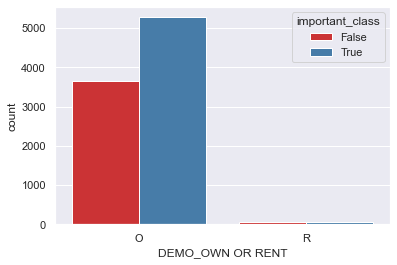

In [8]:
# if the value of the column 'DEMO_OWN OR RENT' is 'U' then replace it with Nan
agr_demo['DEMO_OWN OR RENT'] = agr_demo['DEMO_OWN OR RENT'].replace('U', np.nan)

# Grouping null values in 'DEMO_OWN OR RENT' column by 'important_class' and include null values
print(agr_demo.groupby('important_class')['DEMO_OWN OR RENT'].value_counts(dropna=False))

# visualize the data with a chart 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Grouping null values in 'DEMO_OWN OR RENT' column by 'important_class' and include null values. and chart it. make sure to also plot the null values
sns.countplot(x='DEMO_OWN OR RENT', hue='important_class', data=agr_demo, palette='Set1',)

# print out what percentage of the data is null in the 'DEMO_OWN OR RENT' column. with nice fromating
print("{:.2%} is null in column DEMO_OWN OR RENT".format(agr_demo['DEMO_OWN OR RENT'].isnull().sum()/len(agr_demo['DEMO_OWN OR RENT'])))

# print out what percentage of the data is 'O' in the 'DEMO_OWN OR RENT' column. with nice formatting and explain what it means
print("{:.2%} is 'O' in column DEMO_OWN OR RENT".format((agr_demo['DEMO_OWN OR RENT'] == 'O').sum()/len(agr_demo['DEMO_OWN OR RENT'])))

# print out what percentage of the data is 'R' in the 'DEMO_OWN OR RENT' column
print("{:.2%} is 'R' in column DEMO_OWN OR RENT".format((agr_demo['DEMO_OWN OR RENT'] == 'R').sum()/len(agr_demo['DEMO_OWN OR RENT'])))

# DEMO_OWN OR RENT
As we can see above in the table and chart the majority of the column 'DEMO_OWN OR RENT' is missing at around 59% of the data. Also only .5% of the data contains infomation about renters. so the only information we can gather from this column is that the majority of the data is missing and the data we have is about known owners.

conclusion: use just owners. and create score such that the ratio of important class to not is that that is used in risk model. 

---

### Proportion of owners who belong to important class

1. **Calculate the proportions of owners and renters in the important class (True):**
   - Proportion of owners: 5277 / (6973 + 5277 + 58) = **0.43** (approximately)
   - Proportion of renters: 58 / (6973 + 5277 + 58) = **0.005** (approximately)
   
2. **Calculate the proportions of owners and renters in the non-important class (False):**
   - Proportion of owners: 3663 / (6283 + 3663 + 54) = **0.37** (approximately)
   - Proportion of renters: 54 / (6283 + 3663 + 54) = **0.005** (approximately)

3. **Compare the proportions:**
   - **Owners are more likely to be part of the important class (0.43 > 0.37).**
   - The proportion of renters in both classes is approximately the same (0.005).

---
   
### Odds ratio of owners belonging to important class

One common method to quantify the difference between two proportions is to calculate the odds ratio. The odds ratio is a measure of effect size, describing the strength of association or non-independence between two binary data values.

In this case, we can calculate the odds of being an owner in the important class (True) versus the odds of being an owner in the non-important class (False).

Here's how you can calculate it:

1. **Calculate the odds of being an owner in each class:**

   - Odds in the important class (True): 5277 / (6973 + 58) = **0.75** (approximately)
   - Odds in the non-important class (False): 3663 / (6283 + 54) = **0.58** (approximately)

2. **Calculate the odds ratio:**

   - **Odds ratio = Odds in the important class / Odds in the non-important class = 0.75 / 0.58 = 1.29** (approximately)
   
The odds ratio is a value that allows us to compare the odds of being an owner in the important class versus the non-important class. In this case, an odds ratio of 1.29 suggests that owners are 1.29 times more likely to be in the important class than in the non-important class.



## Conclusion

- O (owners) = 1.29
- R (renters) = 1
- Nan = 1

# DEMO_TYPE OF DWELLING

important_class  DEMO_TYPE OF DWELLING
False            NaN                      6100
                 S                        3848
                 M                          52
True             NaN                      6824
                 S                        5422
                 M                          62
Name: DEMO_TYPE OF DWELLING, dtype: int64
57.94% is null in column DEMO_TYPE OF DWELLING
41.55% is 'S' in column DEMO_TYPE OF DWELLING
0.51% is 'M' in column DEMO_TYPE OF DWELLING


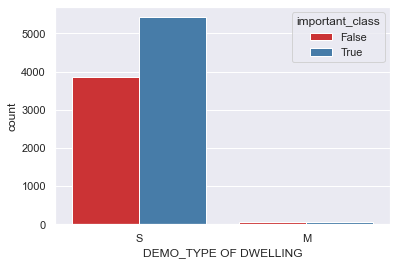

In [9]:
agr_demo['DEMO_TYPE OF DWELLING'] = agr_demo['DEMO_TYPE OF DWELLING'].replace('U', np.nan)
print(agr_demo.groupby('important_class')['DEMO_TYPE OF DWELLING'].value_counts(dropna=False))

sns.countplot(x='DEMO_TYPE OF DWELLING', hue='important_class', data=agr_demo, palette='Set1',)

print("{:.2%} is null in column DEMO_TYPE OF DWELLING".format(agr_demo['DEMO_TYPE OF DWELLING'].isnull().sum()/len(agr_demo['DEMO_TYPE OF DWELLING'])))
print("{:.2%} is 'S' in column DEMO_TYPE OF DWELLING".format((agr_demo['DEMO_TYPE OF DWELLING'] == 'S').sum()/len(agr_demo['DEMO_TYPE OF DWELLING'])))
print("{:.2%} is 'M' in column DEMO_TYPE OF DWELLING".format((agr_demo['DEMO_TYPE OF DWELLING'] == 'M').sum()/len(agr_demo['DEMO_TYPE OF DWELLING'])))

### Proportion of dwelling types who belong to important class

1. **Calculate the proportions of single-family and multi-family dwellings in the important class (True):**
   - Proportion of single-family dwellings: 5422 / (6824 + 5422 + 62) = **0.44** (approximately)
   - Proportion of multi-family dwellings: 62 / (6824 + 5422 + 62) = **0.006** (approximately)
   
2. **Calculate the proportions of single-family and multi-family dwellings in the non-important class (False):**
   - Proportion of single-family dwellings: 3848 / (6100 + 3848 + 52) = **0.39** (approximately)
   - Proportion of multi-family dwellings: 52 / (6100 + 3848 + 52) = **0.006** (approximately)

3. **Compare the proportions:**
   - **Single-family dwellings are more likely to be part of the important class (0.44 > 0.39).**
   - The proportion of multi-family dwellings in both classes is approximately the same (0.006).

---

### Odds ratio of single-family dwellings belonging to important class

We can calculate the odds of being a single-family dwelling in the important class (True) versus the odds of being a single-family dwelling in the non-important class (False).

Here's how you can calculate it:

1. **Calculate the odds of being a single-family dwelling in each class:**
   - Odds in the important class (True): 5422 / (6824 + 62) = **0.79** (approximately)
   - Odds in the non-important class (False): 3848 / (6100 + 52) = **0.63** (approximately)

2. **Calculate the odds ratio:**
   - **Odds ratio = Odds in the important class / Odds in the non-important class = 0.79 / 0.63 = 1.25** (approximately)

The odds ratio is a value that allows us to compare the odds of being a single-family dwelling in the important class versus the non-important class. In this case, an odds ratio of 1.25 suggests that single-family dwellings are 1.25 times more likely to be in the important class than in the non-important class.


# RESIDENTIAL

important_class  RESIDENTIAL
False            Y               8696
                 NaN             1168
                 N                136
True             Y              10875
                 NaN             1300
                 N                133
Name: RESIDENTIAL, dtype: int64
11.06% is null in column RESIDENTIAL
87.73% is 'Y' in column RESIDENTIAL
1.21% is 'N' in column RESIDENTIAL


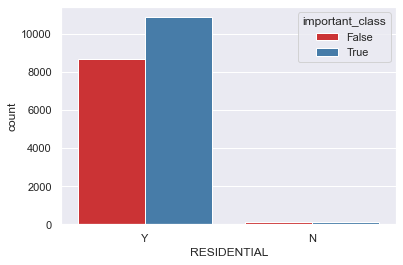

In [10]:
# Grouping null values in 'RESIDENTIAL' column by 'important_class' and include null values
print(agr_demo.groupby('important_class')['RESIDENTIAL'].value_counts(dropna=False))

# Grouping null values in 'RESIDENTIAL' column by 'important_class' and include null values. and chart it. make sure to also plot the null values
sns.countplot(x='RESIDENTIAL', hue='important_class', data=agr_demo, palette='Set1',)

# print out what percentage of the data is null in the 'RESIDENTIAL' column. with nice fromating
print("{:.2%} is null in column RESIDENTIAL".format(agr_demo['RESIDENTIAL'].isnull().sum()/len(agr_demo['RESIDENTIAL'])))
print("{:.2%} is 'Y' in column RESIDENTIAL".format((agr_demo['RESIDENTIAL'] == 'Y').sum()/len(agr_demo['RESIDENTIAL'])))
print("{:.2%} is 'N' in column RESIDENTIAL".format((agr_demo['RESIDENTIAL'] == 'N').sum()/len(agr_demo['RESIDENTIAL'])))

### Proportion of residential status who belong to important class

1. **Calculate the proportions of 'Yes', 'No', and 'NaN' in the important class (True):**
   - Proportion of 'Yes': 10875 / (10875 + 1300 + 133) = **0.87** (approximately)
   - Proportion of 'No': 133 / (10875 + 1300 + 133) = **0.01** (approximately)
   - Proportion of 'NaN': 1300 / (10875 + 1300 + 133) = **0.11** (approximately)

2. **Calculate the proportions of 'Yes', 'No', and 'NaN' in the non-important class (False):**
   - Proportion of 'Yes': 8696 / (8696 + 1168 + 136) = **0.86** (approximately)
   - Proportion of 'No': 136 / (8696 + 1168 + 136) = **0.01** (approximately)
   - Proportion of 'NaN': 1168 / (8696 + 1168 + 136) = **0.12** (approximately)

3. **Compare the proportions:**
   - **'Yes' is slightly more likely to be part of the important class (0.87 > 0.86).**
   - The proportions of 'No' and 'NaN' in both classes are approximately the same (0.01 and 0.12 respectively).

---

### Odds ratio of 'Yes' belonging to important class

We can calculate the odds of being 'Yes' in the important class (True) versus the odds of being 'Yes' in the non-important class (False).

Here's how you can calculate it:

1. **Calculate the odds of being 'Yes' in each class:**
   - Odds in the important class (True): 10875 / (1300 + 133) = **7.88** (approximately)
   - Odds in the non-important class (False): 8696 / (1168 + 136) = **6.89** (approximately)

2. **Calculate the odds ratio:**
   - **Odds ratio = Odds in the important class / Odds in the non-important class = 7.88 / 6.89 = 1.14** (approximately)

The odds ratio is a value that allows us to compare the odds of being 'Yes' in the important class versus the non-important class. In this case, an odds ratio of 1.14 suggests that 'Yes' is 1.14 times more likely to be in the important class than in the non-important class.


# PROPERTY TYPE DESC

important_class  PROPERTY TYPE DESC
False            NaN                   8206
                 R                     1384
                 C                      296
                 A                      114
True             NaN                   9683
                 R                     2176
                 C                      310
                 A                      139
Name: PROPERTY TYPE DESC, dtype: int64
80.19% is null in column PROPERTY TYPE DESC
15.96% is 'R' in column PROPERTY TYPE DESC
2.72% is 'C' in column PROPERTY TYPE DESC
1.13% is 'A' in column PROPERTY TYPE DESC


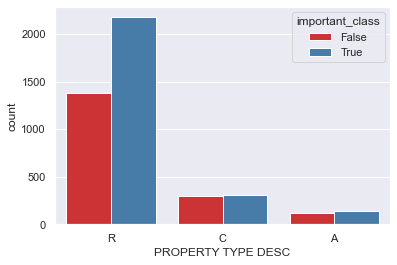

In [11]:
# Grouping null values in 'PROPERTY TYPE DESC' column by 'important_class' and include null values
print(agr_demo.groupby('important_class')['PROPERTY TYPE DESC'].value_counts(dropna=False))

# Grouping null values in 'PROPERTY TYPE DESC' column by 'important_class' and include null values. and chart it. make sure to also plot the null values. update chart so R=RESIDENTIAL, C=COMMERICAL, A=AGRICULTURAL
sns.countplot(x='PROPERTY TYPE DESC', hue='important_class', data=agr_demo, palette='Set1',)

# print out what percentage of the data is null in the 'PROPERTY TYPE DESC' column. with nice fromating
print("{:.2%} is null in column PROPERTY TYPE DESC".format(agr_demo['PROPERTY TYPE DESC'].isnull().sum()/len(agr_demo['PROPERTY TYPE DESC'])))
# print out what percentage of the data is R in the 'PROPERTY TYPE DESC' column. with nice fromating
print("{:.2%} is 'R' in column PROPERTY TYPE DESC".format((agr_demo['PROPERTY TYPE DESC'] == 'R').sum()/len(agr_demo['PROPERTY TYPE DESC'])))
# print out what percentage of the data is C in the 'PROPERTY TYPE DESC' column. with nice fromating
print("{:.2%} is 'C' in column PROPERTY TYPE DESC".format((agr_demo['PROPERTY TYPE DESC'] == 'C').sum()/len(agr_demo['PROPERTY TYPE DESC'])))
# print out what percentage of the data is A in the 'PROPERTY TYPE DESC' column. with nice fromating
print("{:.2%} is 'A' in column PROPERTY TYPE DESC".format((agr_demo['PROPERTY TYPE DESC'] == 'A').sum()/len(agr_demo['PROPERTY TYPE DESC'])))


### Odds ratio of 'R' belonging to important class (R=RESIDENTIAL, C=COMMERICAL, A=AGRICULTURAL)

We can calculate the odds of being 'R' in the important class (True) versus the odds of being 'R' in the non-important class (False).

Here's how you can calculate it:

1. **Calculate the odds of being 'R' in each class:**
   - Odds in the important class (True): 2176 / 9683 = **0.22** (approximately)
   - Odds in the non-important class (False): 1384 / 8206 = **0.17** (approximately)

2. **Calculate the odds ratio:**
   - **Odds ratio = Odds in the important class / Odds in the non-important class = 0.22 / 0.17 = 1.29** (approximately)

The odds ratio is a value that allows us to compare the odds of being 'R' in the important class versus the non-important class. In this case, an odds ratio of 1.29 suggests that 'R' is 1.29 times more likely to be in the important class than in the non-important class.




# DEMO_MARITAL STATUS

important_class  DEMO_MARITAL STATUS
False            NaN                    6032
                 M                      2238
                 S                      1521
                 U                       184
                 A                        23
                 B                         2
True             NaN                    6747
                 M                      3261
                 S                      2061
                 U                       213
                 A                        22
                 B                         4
Name: DEMO_MARITAL STATUS, dtype: int64


<AxesSubplot:xlabel='DEMO_MARITAL STATUS', ylabel='count'>

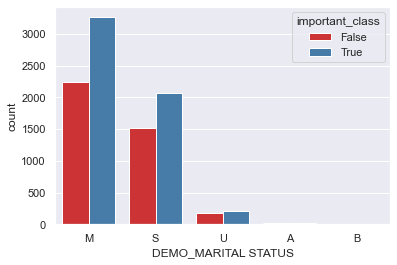

In [12]:
# Grouping null values in 'DEMO_MARITAL STATUS' column by 'important_class' and include null values
print(agr_demo.groupby('important_class')['DEMO_MARITAL STATUS'].value_counts(dropna=False))

# Grouping null values in 'DEMO_MARITAL STATUS' column by 'important_class' and include null values. and chart it. make sure to also plot the null values
sns.countplot(x='DEMO_MARITAL STATUS', hue='important_class', data=agr_demo, palette='Set1',)

### Odds ratio of each possible value ('M', 'S', 'U', 'A', 'B') belonging to important class

We can calculate the odds of being 'M', 'S', 'U', 'A', or 'B' in the important class (True) versus the odds of being 'M', 'S', 'U', 'A', or 'B' in the non-important class (False).

Here's how you can calculate it:

1. **Calculate the odds of being each category in each class:**

   - Odds of 'M' in the important class (True): 3261 / 6747 = **0.48** (approximately)
   - Odds of 'M' in the non-important class (False): 2238 / 6032 = **0.37** (approximately)

   - Odds of 'S' in the important class (True): 2061 / 6747 = **0.31** (approximately)
   - Odds of 'S' in the non-important class (False): 1521 / 6032 = **0.25** (approximately)

   - Odds of 'U' in the important class (True): 213 / 6747 = **0.03** (approximately)
   - Odds of 'U' in the non-important class (False): 184 / 6032 = **0.03** (approximately)

   - Odds of 'A' in the important class (True): 22 / 6747 = **0.003** (approximately)
   - Odds of 'A' in the non-important class (False): 23 / 6032 = **0.004** (approximately)

   - Odds of 'B' in the important class (True): 4 / 6747 = **0.0006** (approximately)
   - Odds of 'B' in the non-important class (False): 2 / 6032 = **0.0003** (approximately)

2. **Calculate the odds ratio for each category:**

   - **Odds ratio of 'M' = Odds in the important class / Odds in the non-important class = 0.48 / 0.37 = 1.30** (approximately)
   
   - **Odds ratio of 'S' = Odds in the important class / Odds in the non-important class = 0.31 / 0.25 = 1.24** (approximately)
   
   - **Odds ratio of 'U' = Odds in the important class / Odds in the non-important class = 0.03 / 0.03 = 1.00** (approximately)
   
   - **Odds ratio of 'A' = Odds in the important class / Odds in the non-important class = 0.003 / 0.004 = 0.75** (approximately)
   
   - **Odds ratio of 'B' = Odds in the important class / Odds in the non-important class = 0.0006 / 0.0003 = 2.00** (approximately)

The odds ratios suggest that 'M', 'S', and 'B' are more likely to be in the important class than in the non-important class, 'U' is equally likely to be in either class, and 'A' is less likely to be in the important class.


# make it work with code

In [23]:
# need to assign a cdc cat to each row in the data set. not sure of a better programatice way to do this so i will do it the old fasion way.
cdc_tier_dict = {
    'DPV': '',
    'SCF': '',
    'VACANT': '',
    'NO STAT': '',
    'RESIDENTIAL': '',
    'MOVED_CD': '',
    'ANK': '',
    'ORIG_ADDRESS': '',
    'ORIG_CITY': '',
    'ORIG_STATE': '',
    'ORIG_ZIP': '',
    'NCOA DATE': '',
    'MOVETYPE': '',
    'AGR_RECORD': '',
    'MASTER_DOB': '',
    'AGR_DOB': '',
    'CLIENT_DOB': '',
    'DEMO MATCH': '',
    'PROP MATCH': '',
    'IL_SCORE_AGR': '',
    'MATCH IL': '',
    'DEMO_TYPE OF DWELLING': '',
    'DEMO_ESTIMATED INCOME': '',
    'DEMO_OWN OR RENT': '',
    'DEMO_CHILDREN': '',
    'DEMO_MARITAL STATUS': '',
    'DEMO_EDUCATION LEVEL': '',
    'DEMO_CREDIT RATING': '',
    'DEMO_VETERAN PRESENT IN HH': '',
    'PDLLF': '',
    'PDLSF': '',
    'CREDIT REPAIR': '',
    'DEBT CONSOLIDATION': '',
    'LOAN AMOUNT 1': '',
    'LOAD DATE 1': '',
    'LOAD RECORDING DATE 1': '',
    'MULTIPLE PROPERTIES COUNT': '',
    'MULTIPLE PROPERTIES FLAG': '',
    'OWNER OCCUPIED STATUS': '',
    'OWNER STATUS TYPE': '',
    'OWNERSHIP START DATE': '',
    'PROPERTY TYPE DESC': 'tier2',
    'PURCHASE PRICE': '',
    'PURCHASE RECORDING DATE': '',
    'PURCHASE SALE DATE': '',
    'BANKRUPCY': '',
    'BANKRUPTCY DATE': '',
    'BANKRUPTCY STATUS': '',
    'DUI': '',
    'SEX OFFENDER DATE': '',
    'SEX OFFENDER': '',
    'DIGITAL FLAG': '',
}



In [37]:
# columns to look at
list_of_col_names = ['DPV', 'SCF', 'VACANT', 'NO STAT', 'RESIDENTIAL', 'MOVED_CD', 'ANK', 'ORIG_ADDRESS', 'ORIG_CITY', 'ORIG_STATE', 'ORIG_ZIP', 'NCOA DATE', 'MOVETYPE', 'AGR_RECORD', 'MASTER_DOB', 'AGR_DOB', 'CLIENT_DOB', 'DEMO MATCH', 'PROP MATCH', 'IL_SCORE_AGR', 'MATCH IL', 'DEMO_TYPE OF DWELLING', 'DEMO_ESTIMATED INCOME', 'DEMO_OWN OR RENT', 'DEMO_CHILDREN', 'DEMO_MARITAL STATUS', 'DEMO_EDUCATION LEVEL', 'DEMO_CREDIT RATING', 'DEMO_VETERAN PRESENT IN HH', 'PDLLF', 'PDLSF', 'CREDIT REPAIR', 'DEBT CONSOLIDATION', 'LOAN AMOUNT 1', 'LOAD DATE 1', 'LOAD RECORDING DATE 1', 'MULTIPLE PROPERTIES COUNT', 'MULTIPLE PROPERTIES FLAG', 'OWNER OCCUPIED STATUS', 'OWNER STATUS TYPE', 'OWNERSHIP START DATE', 'PROPERTY TYPE DESC', 'PURCHASE PRICE', 'PURCHASE RECORDING DATE', 'PURCHASE SALE DATE', 'BANKRUPCY', 'BANKRUPTCY DATE', 'BANKRUPTCY STATUS', 'DUI', 'SEX OFFENDER', 'DIGITAL FLAG']

In [49]:
def calculate_proportions_and_odds(df, column, class_column, value):
    """
    Calculates the proportions and odds for a specific value in a column.

    Args:
        df (DataFrame): The pandas dataframe containing the data.
        column (str): The column for which the odds are being calculated.
        class_column (str): The column indicating the class (true or false) for each row.
        value (str): The specific value for which the odds are being calculated.

    Returns:
        float: The odds ratio for the specific value.
    """
    class_true = df[df[class_column] == True]
    class_false = df[df[class_column] == False]

    prop_true = (class_true[column] == value).sum() / len(class_true)
    prop_false = (class_false[column] == value).sum() / len(class_false)

    odds_true = prop_true / (1 - prop_true) if prop_true != 1 else float('inf')
    odds_false = prop_false / (1 - prop_false) if prop_false != 1 else float('inf')

    odds_ratio = odds_true / odds_false if odds_false != 0 else float('inf')

    return odds_ratio


def get_column_info(df, column, class_column):
    """
    Retrieves information about a specific column.

    Args:
        df (DataFrame): The pandas dataframe containing the data.
        column (str): The column for which information is being retrieved.
        class_column (str): The column indicating the class (true or false) for each row.

    Returns:
        dict: A dictionary containing information about each unique value in the column.
    """

    unique_values = df[column].dropna().unique()

    # Calculate the percentage of null values for each column
    null_percentages = df[column].isnull().mean()

    # Calculate the threshold for inclusion in the risk score
    threshold = (1.0 / (len(unique_values))) * (1 - null_percentages)

    column_info = {}
    for value in unique_values:
        # Calculate the proportions and odds for each class, scaling by the null percentages
        odds_ratio = calculate_proportions_and_odds(df, column, class_column, value)

        # Calculate the percentage of data that comprises a given value
        percentage = (df[column] == value).sum() / len(df)

        # Add the results to the dictionary
        column_info[str(value)] = {
            'odds_ratio': odds_ratio,
            'percentage': "{:.2%}".format(percentage),
            'threshold': "{:.2%}".format(threshold),
        }

    return column_info


# this function will calculate the odds ratio for a given column in the dataframe

def calculate_odds_ratio(df, class_column, columns):
    """
    Main function that builds the JSON structure, determines each column's data type, 
    and fills in the details for each unique value using helper functions.

    Args:
        df (DataFrame): The pandas dataframe containing the data.
        class_column (str): The column indicating the class (true or false) for each row.
        columns (list): List of columns for which odds ratios need to be calculated.

    Returns:
        str: A JSON-like string containing the calculated odds ratios.
    """
    results = {}

    for column in columns:
        col_name = str(column)

        if df[column].isnull().all():
            results[col_name] = {
                'data_type': 'empty_col',
                'cdc_cat': cdc_tier_dict.get(column, ''),
                'data_origin': df.name,
                'unique_row_values': {}
            }
            continue

        results[col_name] = {
            'data_type': '',
            'cdc_cat': cdc_tier_dict.get(column, ''),
            'data_origin': df.name,
            'unique_row_values': {}
        }

        if len(df[column].dropna().unique()) > 50:
            results[col_name]['data_type'] = 'continuous'
        else:
            results[col_name]['data_type'] = 'categorical'
            results[col_name]['unique_row_values'] = get_column_info(df, column, class_column)

    return json.dumps(results, indent=4)


results_json = calculate_odds_ratios(agr_demo, 'important_class', list_of_col_names)
# save the results to a file
with open('results.json', 'w') as f:
    f.write(results_json)
print(results_json)



{
    "DPV": {
        "data_type": "categorical",
        "cdc_cat": "",
        "data_origin": "AGR Demographics dataset",
        "unique_row_values": {
            "1": {
                "odds_ratio": 1.1780959654238405,
                "percentage": "82.92%",
                "threshold": "50.00%"
            },
            "0": {
                "odds_ratio": 0.8488272851696189,
                "percentage": "17.08%",
                "threshold": "50.00%"
            }
        }
    },
    "SCF": {
        "data_type": "continuous",
        "cdc_cat": "",
        "data_origin": "AGR Demographics dataset",
        "unique_row_values": {}
    },
    "VACANT": {
        "data_type": "categorical",
        "cdc_cat": "",
        "data_origin": "AGR Demographics dataset",
        "unique_row_values": {
            "0.0": {
                "odds_ratio": 1.1431672275908698,
                "percentage": "87.11%",
                "threshold": "44.47%"
            },
            "1.0": {
 

In [54]:
# this is not working as of now

import json

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def transform_data(data):
    transformed_data = {}

    for key, value in data.items():
        unique_row_values = value.get('unique_row_values', {})

        row_list = [{'state': k, 'odds_ratio': v['odds_ratio'], 'percentage': v['percentage'], 'threshold': v['threshold']} 
                    for k, v in unique_row_values.items() if v.get('odds_ratio') not in [None, 'Infinity']]

        row_list.sort(key=lambda x: x['odds_ratio'], reverse=True)

        transformed_data[key] = row_list

    return transformed_data

file_path = 'results.json'  # replace with your actual file path
data = load_json(file_path)
transformed_data = transform_data(data)

# view the transformed data as a nicely formatted json
print(json.dumps(transformed_data, indent=4))

{
    "DPV": [
        {
            "state": "1",
            "odds_ratio": 1.1780959654238405,
            "percentage": "82.92%",
            "threshold": "50.00%"
        },
        {
            "state": "0",
            "odds_ratio": 0.8488272851696189,
            "percentage": "17.08%",
            "threshold": "50.00%"
        }
    ],
    "SCF": [],
    "VACANT": [
        {
            "state": "0.0",
            "odds_ratio": 1.1431672275908698,
            "percentage": "87.11%",
            "threshold": "44.47%"
        },
        {
            "state": "1.0",
            "odds_ratio": 0.8012523363880492,
            "percentage": "1.82%",
            "threshold": "44.47%"
        }
    ],
    "NO STAT": [
        {
            "state": "0.0",
            "odds_ratio": 1.153289372148565,
            "percentage": "85.31%",
            "threshold": "44.47%"
        },
        {
            "state": "1.0",
            "odds_ratio": 0.8228571428571428,
            "percentag

In [55]:
# print a list of evey colunm in the dataset
print(list(agr_demo.columns))

['source_id', 'COA_DATE', 'DPV', 'SCF', 'VACANT', 'NO STAT', 'RESIDENTIAL', 'MOVED_CD', 'ANK', 'ORIG_ADDRESS', 'ORIG_CITY', 'ORIG_STATE', 'ORIG_ZIP', 'NCOA DATE', 'MOVETYPE', 'AGR_RECORD', 'MASTER_DOB', 'AGR_DOB', 'CLIENT_DOB', 'DEMO MATCH', 'PROP MATCH', 'IL_SCORE_AGR', 'MATCH IL', 'DEMO_TYPE OF DWELLING', 'DEMO_ESTIMATED INCOME', 'DEMO_OWN OR RENT', 'DEMO_CHILDREN', 'DEMO_MARITAL STATUS', 'DEMO_EDUCATION LEVEL', 'DEMO_CREDIT RATING', 'DEMO_VETERAN PRESENT IN HH', 'PDLLF', 'PDLSF', 'CREDIT REPAIR', 'DEBT CONSOLIDATION', 'LOAN AMOUNT 1', 'LOAD DATE 1', 'LOAD RECORDING DATE 1', 'MULTIPLE PROPERTIES COUNT', 'MULTIPLE PROPERTIES FLAG', 'OWNER OCCUPIED STATUS', 'OWNER STATUS TYPE', 'OWNERSHIP START DATE', 'PROPERTY TYPE DESC', 'PURCHASE PRICE', 'PURCHASE RECORDING DATE', 'PURCHASE SALE DATE', 'BANKRUPCY', 'BANKRUPTCY DATE', 'BANKRUPTCY STATUS', 'DUI', 'SEX OFFENDER DATE', 'SEX OFFENDER', 'DIGITAL FLAG', 'important_class']


In [9]:
# print the name of the dataframe
print(agr_demo.name())

AttributeError: 'DataFrame' object has no attribute 'name'

In [ ]:
# drop 'is_suicide'
agr_demo = agr_demo.drop(columns='is_suicide')

In [ ]:
# write the cleaned data to a csv file
agr_demo.to_csv('data/out/agr_demo_cleaned_v1.csv', index=False)